## Notebook Processing
### Yuritzy Pérez 14/09/2023
#### Basado en:
#### Automated Data Cleaning with Python: Elise Landman
##### How to automate data preparation and save time on your next data science project

### ¿Qué queremos automatizar?
#### Los pasos que se deben automatizar son aquellos que se repiten constantemente en casi todos los proyectos de ciencia de datos. Lo que se construirá es necesario que sea válido para varios datasets para que pueda ser útil en distintos contextos. Por ejemplo, existen tareas repetidas en las mayorias de los proyectos como lo son revisar formato de los datos, tipos de datos, datos faltantes o si hay outliers. 
### Construcción
#### Se importan las librerias que se utilizaran en el proyecto.

In [1]:
import numpy as np
import pandas as pd
from math import isnan
from sklearn import preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#### Definiremos que nuestro script tomará un marco de datos Pandas como entrada, lo que significa que necesitamos al menos transformar los datos a un formato de marco de datos Pandas antes de que puedan ser procesados por nuestro pipeline.

#### Ahora veamos los bloques de construcción de nuestro pipeline. Los siguientes capítulos recorrerán los siguientes pasos de procesamiento:
#### [Bloque 1] Valores faltantes
#### [Bloque 2] Valores atípicos
#### [Bloque 3] Codificación categórica
#### [Bloque 4] Extracción de características de fecha y hora
#### [Bloque 5] Pasos de pulido

### Valores Faltantes
#### Es muy común que un dataset tenga datos faltantes por lo que se deberá elegir que hacer con ellos, se pueden eliminar, usar tecnicas de imputación o predecir valores por medio de regresiones o clasificación. Las técnicas de imputación sustituyen los datos que faltan por determinados valores, como la media, o por un valor similar a otros valores de muestra en el espacio de características.

#### La elección de cómo tratar los valores que faltan dependerá sobre todo de: el tipo de datos (numéricos o categóricos) y el número de valores que faltan en relación con el número total de muestras (eliminar 1 observación de 100k tendrá un impacto diferente que eliminar 1 de 100).

#### El código seguirá la estrategia imputación > eliminación, y soportará las siguientes técnicas: predicción con Regresión Lineal y Logística, imputación con K-NN, media, mediana y moda, así como eliminación.

#### Descripción de la función: Primero crearemos una clase separada para manejar los valores perdidos. La función que manejamos a continuación tratará los valores perdidos numéricos y categóricos de forma diferente: algunas técnicas de imputación pueden ser aplicables sólo para datos numéricos, mientras que otras sólo para datos categóricos. Veamos la primera parte de la función, que se ocupa de las características numéricas:

In [ ]:
class MissingValues:

    def handle(self, df, _n_neighbors=3):
        # function for handling missing values in the data
        if self.missing_num or self.missing_categ:
            logger.info('Started handling of missing values...', str(self.missing_num).upper())
            start = timer()
            self.count_missing = df.isna().sum().sum()

            if self.count_missing != 0:
                logger.info('Found a total of {} missing value(s)', self.count_missing)
                df = df.dropna(how='all')
                df.reset_index(drop=True)
                
                if self.missing_num: # numeric data
                    logger.info('Started handling of NUMERICAL missing values... Method: "{}"', str(self.missing_num).upper())
                    # automated handling
                    if self.missing_num == 'auto': 
                        self.missing_num = 'linreg'
                        lr = LinearRegression()
                        df = MissingValues._lin_regression_impute(self, df, lr)
                        self.missing_num = 'knn'
                        imputer = KNNImputer(n_neighbors=_n_neighbors)
                        df = MissingValues._impute(self, df, imputer, type='num')
                    # linear regression imputation
                    elif self.missing_num == 'linreg':
                        lr = LinearRegression()
                        df = MissingValues._lin_regression_impute(self, df, lr)
                    # knn imputation
                    elif self.missing_num == 'knn':
                        imputer = KNNImputer(n_neighbors=_n_neighbors)
                        df = MissingValues._impute(self, df, imputer, type='num')
                    # mean, median or mode imputation
                    elif self.missing_num in ['mean', 'median', 'most_frequent']:
                        imputer = SimpleImputer(strategy=self.missing_num)
                        df = MissingValues._impute(self, df, imputer, type='num')
                    # delete missing values
                    elif self.missing_num == 'delete':
                        df = MissingValues._delete(self, df, type='num')
                        logger.debug('Deletion of {} NUMERIC missing value(s) succeeded', self.count_missing-df.isna().sum().sum())      

                if self.missing_categ: # categorical data
                    logger.info('Started handling of CATEGORICAL missing values... Method: "{}"', str(self.missing_categ).upper())
                    # automated handling
                    if self.missing_categ == 'auto':
                        self.missing_categ = 'logreg'
                        lr = LogisticRegression()
                        df = MissingValues._log_regression_impute(self, df, lr)
                        self.missing_categ = 'knn'
                        imputer = KNNImputer(n_neighbors=_n_neighbors)
                        df = MissingValues._impute(self, df, imputer, type='categ')
                    elif self.missing_categ == 'logreg':
                        lr = LogisticRegression()
                        df = MissingValues._log_regression_impute(self, df, lr)
                    # knn imputation
                    elif self.missing_categ == 'knn':
                        imputer = KNNImputer(n_neighbors=_n_neighbors)
                        df = MissingValues._impute(self, df, imputer, type='categ')  
                    # mode imputation
                    elif self.missing_categ == 'most_frequent':
                        imputer = SimpleImputer(strategy=self.missing_categ)
                        df = MissingValues._impute(self, df, imputer, type='categ')
                    # delete missing values                    
                    elif self.missing_categ == 'delete':
                        df = MissingValues._delete(self, df, type='categ')
                        logger.debug('Deletion of {} CATEGORICAL missing value(s) succeeded', self.count_missing-df.isna().sum().sum())
            else:
                logger.debug('{} missing values found', self.count_missing)
            end = timer()
            logger.info('Completed handling of missing values in {} seconds', round(end-start, 6))  
        else:
            logger.info('Skipped handling of missing values')
        return df

    def _impute(self, df, imputer, type):
        # function for imputing missing values in the data
        cols_num = df.select_dtypes(include=np.number).columns 

        if type == 'num':
            # numerical features
            for feature in df.columns: 
                if feature in cols_num:
                    if df[feature].isna().sum().sum() != 0:
                        try:
                            df_imputed = pd.DataFrame(imputer.fit_transform(np.array(df[feature]).reshape(-1, 1)))
                            counter = df[feature].isna().sum().sum() - df_imputed.isna().sum().sum()

                            if (df[feature].fillna(-9999) % 1  == 0).all():
                                df[feature] = df_imputed
                                # round back to INTs, if original data were INTs
                                df[feature] = df[feature].round()
                                df[feature] = df[feature].astype('Int64')                                        
                            else:
                                df[feature] = df_imputed
                            if counter != 0:
                                logger.debug('{} imputation of {} value(s) succeeded for feature "{}"', str(self.missing_num).upper(), counter, feature)
                        except:
                            logger.warning('{} imputation failed for feature "{}"', str(self.missing_num).upper(), feature)
        else:
            # categorical features
            for feature in df.columns:
                if feature not in cols_num:
                    if df[feature].isna().sum()!= 0:
                        try:
                            mapping = dict()
                            mappings = {k: i for i, k in enumerate(df[feature].dropna().unique(), 0)}
                            mapping[feature] = mappings
                            df[feature] = df[feature].map(mapping[feature])

                            df_imputed = pd.DataFrame(imputer.fit_transform(np.array(df[feature]).reshape(-1, 1)), columns=[feature])    
                            counter = sum(1 for i, j in zip(list(df_imputed[feature]), list(df[feature])) if i != j)

                            # round to integers before mapping back to original values
                            df[feature] = df_imputed
                            df[feature] = df[feature].round()
                            df[feature] = df[feature].astype('Int64')  

                            # map values back to original
                            mappings_inv = {v: k for k, v in mapping[feature].items()}
                            df[feature] = df[feature].map(mappings_inv)
                            if counter != 0:
                                logger.debug('{} imputation of {} value(s) succeeded for feature "{}"', self.missing_categ.upper(), counter, feature)
                        except:
                            logger.warning('{} imputation failed for feature "{}"', str(self.missing_categ).upper(), feature)
        return df

    def _lin_regression_impute(self, df, model):
        # function for predicting missing values with linear regression
        cols_num = df.select_dtypes(include=np.number).columns
        mapping = dict()
        for feature in df.columns:
            if feature not in cols_num:
                # create label mapping for categorical feature values
                mappings = {k: i for i, k in enumerate(df[feature])}
                mapping[feature] = mappings
                df[feature] = df[feature].map(mapping[feature])
        for feature in cols_num: 
                try:
                    test_df = df[df[feature].isnull()==True].dropna(subset=[x for x in df.columns if x != feature])
                    train_df = df[df[feature].isnull()==False].dropna(subset=[x for x in df.columns if x != feature])
                    if len(test_df.index) != 0:
                        pipe = make_pipeline(StandardScaler(), model)

                        y = np.log(train_df[feature]) # log-transform the data
                        X_train = train_df.drop(feature, axis=1)
                        test_df.drop(feature, axis=1, inplace=True)
                        
                        try:
                            model = pipe.fit(X_train, y)
                        except:
                            y = train_df[feature] # use non-log-transformed data
                            model = pipe.fit(X_train, y)
                        if (y == train_df[feature]).all():
                            pred = model.predict(test_df)
                        else:
                            pred = np.exp(model.predict(test_df)) # predict values

                        test_df[feature]= pred

                        if (df[feature].fillna(-9999) % 1  == 0).all():
                            # round back to INTs, if original data were INTs
                            test_df[feature] = test_df[feature].round()
                            test_df[feature] = test_df[feature].astype('Int64')
                            df[feature].update(test_df[feature])                          
                        else:
                            df[feature].update(test_df[feature])  
                        logger.debug('LINREG imputation of {} value(s) succeeded for feature "{}"', len(pred), feature)
                except:
                    logger.warning('LINREG imputation failed for feature "{}"', feature)
        for feature in df.columns: 
            try:   
                # map categorical feature values back to original
                mappings_inv = {v: k for k, v in mapping[feature].items()}
                df[feature] = df[feature].map(mappings_inv)
            except:
                pass
        return df

    def _log_regression_impute(self, df, model):
        # function for predicting missing values with logistic regression
        cols_num = df.select_dtypes(include=np.number).columns
        mapping = dict()
        for feature in df.columns:
            if feature not in cols_num:
                # create label mapping for categorical feature values
                mappings = {k: i for i, k in enumerate(df[feature])} #.dropna().unique(), 0)}
                mapping[feature] = mappings
                df[feature] = df[feature].map(mapping[feature])

        target_cols = [x for x in df.columns if x not in cols_num]
            
        for feature in df.columns: 
            if feature in target_cols:
                try:
                    test_df = df[df[feature].isnull()==True].dropna(subset=[x for x in df.columns if x != feature])
                    train_df = df[df[feature].isnull()==False].dropna(subset=[x for x in df.columns if x != feature])
                    if len(test_df.index) != 0:
                        pipe = make_pipeline(StandardScaler(), model)

                        y = train_df[feature]
                        train_df.drop(feature, axis=1, inplace=True)
                        test_df.drop(feature, axis=1, inplace=True)

                        model = pipe.fit(train_df, y)
                        
                        pred = model.predict(test_df) # predict values
                        test_df[feature]= pred

                        if (df[feature].fillna(-9999) % 1  == 0).all():
                            # round back to INTs, if original data were INTs
                            test_df[feature] = test_df[feature].round()
                            test_df[feature] = test_df[feature].astype('Int64')
                            df[feature].update(test_df[feature])                             
                        logger.debug('LOGREG imputation of {} value(s) succeeded for feature "{}"', len(pred), feature)
                except:
                    logger.warning('LOGREG imputation failed for feature "{}"', feature)
        for feature in df.columns: 
            try:
                # map categorical feature values back to original
                mappings_inv = {v: k for k, v in mapping[feature].items()}
                df[feature] = df[feature].map(mappings_inv)
            except:
                pass     
        return df

    def _delete(self, df, type):
        # function for deleting missing values
        cols_num = df.select_dtypes(include=np.number).columns 
        if type == 'num':
            # numerical features
            for feature in df.columns: 
                if feature in cols_num:
                    df = df.dropna(subset=[feature])
                    df.reset_index(drop=True)
        else:
            # categorical features
            for feature in df.columns:
                if feature not in cols_num:
                    df = df.dropna(subset=[feature])
                    df.reset_index(drop=True)
        return df    

#### Esta función comprueba qué método de tratamiento se ha elegido para las características numéricas y categóricas. El ajuste por defecto es "auto", lo que significa que los valores numéricos perdidos se imputarán primero mediante predicción con Regresión Lineal, y los valores restantes se imputarán con K-NN los valores categóricos perdidos se imputarán primero mediante predicción con Regresión Logística, y los valores restantes se imputarán con K-NN.

#### En el caso de las características categóricas, se aplica el mismo principio que el anterior, salvo que sólo admitiremos la imputación con Regresión logística, K-NN e imputación de modo. Cuando utilicemos K-NN, primero codificaremos nuestras características categóricas en números enteros, utilizaremos estas etiquetas para predecir nuestros valores perdidos y, finalmente, volveremos a asignar las etiquetas a sus valores originales.

#### Dependiendo del método de manipulación elegido, la función handle llama a las funciones necesarias dentro de su clase para manipular los datos con la ayuda de varios paquetes de Sklearn: la función _impute se encargará de la imputación K-NN, media, mediana y modo, _lin_regression_impute y log_regression_impute realizarán la imputación a través de la predicción, y supongo que el papel de _delete se explica por sí mismo.

#### La estructura final de nuestra clase MissingValues será la siguiente:

In [ ]:

class MissingValues:
    def handle(df, missing_num='auto', missing_categ='auto', _n_neighbors=3):
        ...
    def _impute(df, imputer, type):
        ...
    def _lin_regression_impute(df, model):
        ...
    def _log_regression_impute(df, model):
        ...
    def _delete(df, type):
        ...

#### Después de haber terminado todos los pasos requeridos, nuestra función da salida a los datos de entrada procesados.

### Valores atípicos
#### Nuestro segundo bloque se centrará en el tratamiento de los valores atípicos en nuestros datos. Primero tenemos que preguntarnos: ¿cuándo consideramos que un valor es un valor atípico? Para nuestro pipeline, utilizaremos una regla comúnmente aplicada que dice que un punto de datos puede considerarse un valor atípico si se encuentra fuera del siguiente rango

#### [Q1 - 1,5 * IQR ; Q3 + 1,5 * IQR]

 ##### donde Q1 y Q3 son los cuartiles 1 y 3 e IQR es el rango intercuartílico.
 
#### Una vez definido qué es un valor atípico, debemos decidir cómo tratarlo. Existen de nuevo varias estrategias para hacerlo, y para nuestro caso de uso nos centraremos en las dos siguientes: winsorización y eliminación.

##### La winsorización se utiliza en estadística para limitar los valores extremos de los datos y reducir el efecto de los valores atípicos sustituyéndolos por un percentil específico de los datos.

#### Al utilizar winsorization, volveremos a utilizar nuestro rango definido anteriormente para reemplazar los valores atípicos:

#### los valores > límite superior se sustituirán por el valor del rango superior y
#### valores < límite inferior serán reemplazados por el valor del rango inferior.

#### La estructura final de nuestra clase Outliers será la siguiente:

In [ ]:
class Outliers:
    # Function that handles outliers in the data
    def handle(df, outliers='winz'):
        if outliers:
            if outliers == 'winz':  
                df = Outliers._winsorization(self, df)
            elif ourliers == 'delete':
                df = Outliers._delete(self, df)
        return df     
    def _winsorization(df):
        ...
    def _delete(df):
        ...
    def _compute_bounds(df, feature):
        ...

### Configuración categórica
#### Para poder realizar cálculos con datos categóricos, en la mayoría de los casos necesitamos que nuestros datos sean de tipo numérico, es decir, números o enteros. Por lo tanto, las técnicas más comunes consisten en codificar los datos de una sola vez o codificarlos con etiquetas.

#### La codificación de datos en un solo paso representa cada valor único de una característica como un vector binario, mientras que la codificación de etiquetas asigna un número entero único a cada valor.

#### Hay varios pros y contras para cada uno de los métodos, como por ejemplo el hecho de que la codificación de una sola vez produce muchas características adicionales. Además, si codificamos con etiquetas, éstas podrían ser interpretadas por ciertos algoritmos como matemáticamente dependientes: 1 manzana + 1 naranja = 1 plátano, lo que obviamente es una interpretación errónea de este tipo de datos categóricos.

#### Estrategia por defecto 'auto' para realizar la codificación de acuerdo con las siguientes reglas:
##### si la característica contiene < 10 valores únicos, se codificará de una sola vez
##### si la característica contiene < 20 valores únicos, se codificará con etiquetas
##### si la característica contiene más de 20 valores únicos, no se codificará.
#### Se trata de una forma bastante primitiva y rápida de gestionar el proceso de codificación, que puede resultar útil, pero que también puede dar lugar a codificaciones no del todo apropiadas para nuestros datos. Aunque la automatización es genial, queremos asegurarnos de que también podemos definir manualmente qué características deben ser codificadas, y cómo. Esto se implementa en la función handle de la clase EncodeCateg:

In [ ]:
class EncodeCateg:
    # Function for encoding of categorical features
    # to specify columns set encode_categ to: ['auto', ['col1', col2']]
    def handle(df, encode_categ=['auto']):
        if encode_categ[0]:
            # select non numeric features
            cols_categ = set(df.columns) ^ set(df.select_dtypes(include=np.number).columns)
            # check if all columns should be encoded
            if len(encode_categ) == 1:
                target_cols = cols_categ # encode ALL columns
            else:
                target_cols = encode_categ[1] # encode only specific columns
            for feature in target_cols:
                if feature in cols_categ:
                    feature = feature # columns are column names
                else:
                    feature = df.columns[feature] # columns are indexes
                try:
                    # skip encoding of datetime features
                    pd.to_datetime(df[feature])
                except:
                    try:
                        if encode_categ[0] == 'auto':
                            # ONEHOT encode if not more than 10 unique values to encode
                            if df[feature].nunique() <=10:
                                df = EncodeCateg._to_onehot(df, feature)
                            # LABEL encode if not more than 20 unique values to encode
                            elif df[feature].nunique() <=20:
                                df = EncodeCateg._to_label(df, feature)
                            # skip encoding if more than 20 unique values to encode
                        elif encode_categ[0] == 'onehot':
                            df = EncodeCateg._to_onehot(df, feature)
                        elif encode_categ[0] == 'label':
                            df = EncodeCateg._to_label(df, feature)
                    except:
                        pass
        return df
    def _to_onehot(df, feature, limit=10):
        ...
    def _to_label(df, feature):
        ...

#### La función handle toma una lista como entrada, mientras que las características que queremos codificar manualmente pueden definirse mediante nombres de columnas o índices, como se indica a continuación:

In [ ]:
encode_categ = [‘onehot’, [‘column_name’, 2]]

### Extracción de características de fecha y hora
#### Si nuestro conjunto de datos contiene una característica que tiene valores de fecha y hora, como marcas de tiempo o fechas, es muy probable que queramos extraerlos para que sean más fáciles de manejar cuando los procesemos o visualicemos más adelante.
#### También podemos hacerlo de forma automatizada: dejaremos que nuestro código busque entre las características y compruebe si alguna de ellas se puede convertir al tipo datetime. En caso afirmativo, podemos asumir con seguridad que esta característica contiene valores de fecha y hora.

In [ ]:
# Feature for extracting datetime values
def convert_datetime(df, extract_datetime='s'):
    cols = set(df.columns) ^ set(df.select_dtypes(include=np.number).columns) 
    for feature in cols: 
        try:
            # convert features encoded as strings to type datetime ['D','M','Y','h','m','s']
            df[feature] = pd.to_datetime(df[feature], infer_datetime_format=True)
            df['Day'] = pd.to_datetime(df[feature]).dt.day
            if extract_datetime in ['M','Y','h','m','s']:
                df['Month'] = pd.to_datetime(df[feature]).dt.month
                if extract_datetime in ['Y','h','m','s']:
                    df['Year'] = pd.to_datetime(df[feature]).dt.year
                    if extract_datetime in ['h','m','s']:
                        df['Hour'] = pd.to_datetime(df[feature]).dt.hour
                        if extract_datetime in ['m','s']:
                            df['Minute'] = pd.to_datetime(df[feature]).dt.minute
                            if extract_datetime in ['s']:
                              df['Sec'] = pd.to_datetime(df[feature]).dt.second
            try: # check if entries for the extracted dates/times are valid, otherwise drop
                if (df['Hour'] == 0).all() and (df['Minute'] == 0).all() and (df['Sec'] == 0).all():
                    df.drop('Hour', inplace = True, axis =1 )
                    df.drop('Minute', inplace = True, axis =1 )
                    df.drop('Sec', inplace = True, axis =1 )
                elif (df['Day'] == 0).all() and (df['Month'] == 0).all() and (df['Year'] == 0).all():
                    df.drop('Day', inplace = True, axis =1 )
                    df.drop('Month', inplace = True, axis =1 )
                    df.drop('Year', inplace = True, axis =1 )  
            except:
                pass

#### Podemos definir la granularidad con la que se extraen las características de fecha y hora, mientras que el valor predeterminado es 's' para segundos. Tras la extracción, la función comprueba si las entradas de fechas y horas tienen un significado válido: si las columnas extraídas 'Día', 'Mes' y 'Año' contienen todas 0's, se borrarán las tres. Lo mismo ocurre con "Hora", "Minuto" y "Seg".

### Pulir Dataframe

#### Ahora que hemos procesado nuestro conjunto de datos, todavía tenemos que hacer algunos ajustes para que nuestro marco de datos "tenga buen aspecto". ¿Qué quiero decir con esto?

#### En primer lugar, algunas características que originalmente eran de tipo entero podrían haberse convertido en flotantes, debido a técnicas de imputación u otros pasos de procesamiento que se aplicaron. Antes de dar salida a nuestro marco de datos final, volveremos a convertir estos valores en enteros.

#### En segundo lugar, queremos redondear todas las características flotantes de nuestro conjunto de datos al mismo número de decimales que tenían en nuestro conjunto de datos de entrada original. Esto es para evitar, por un lado, los innecesarios 0 finales en los decimales flotantes y, por otro, para asegurarnos de no redondear nuestros valores más que los valores originales.

## Poniendo todo junto

### Ejemplo de código con dataset
#### El ejemplo que utilizaré para aplicar lo visto será con la fechas de mis datos, para ello usaré el código del artículo

#### Comenzaremos cargando las librerías que se van a utilizar para los datos NetCDF. Primero convertiré mis variables a DataFrames de pandas.

In [3]:
import xarray as xr
import pandas as pd

# Cargar el archivo NetCDF
data = xr.open_dataset('dopplerscatt_20211020_140315.tomoL2CF.nc')

# Seleccionamos la variable "mean_observation_time" que dio problemas para limpiarse durante la práctica anterior.
variable_name = 'mean_observation_time'
selected_variable = data[variable_name]

# Convertimos la variable seleccionada a un DataFame
df = selected_variable.to_dataframe()

# imprimimos el DataFrame para observarlo
print(df)




E:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
E:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
E:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
E:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
E:\ProgramData\anaconda3\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


                                mean_observation_time
line y            x                                  
2    4.110367e+06 238455.893939                   NaT
                  238655.881123                   NaT
                  238855.868306                   NaT
                  239055.855490                   NaT
                  239255.842674                   NaT
...                                               ...
9    4.219560e+06 429043.680078                   NaT
                  429243.667261                   NaT
                  429443.654445                   NaT
                  429643.641629                   NaT
                  429843.628813                   NaT

[4192208 rows x 1 columns]


#### Una vez que ya lo tenemos convetido, podemos aplicar el código del artículo, tal cual lo menciona, pero para nuestro Dataset.

In [5]:
from AutoClean import AutoClean
pipeline = AutoClean(df)

pipeline.output

AutoClean process completed in 12.112933 seconds
Logfile saved to: C:\Users\lic.-Ing.Yuri\Documents\ICD\autoclean.log


,mean_observation_time,Day,Month,Year,Hour,Minute,Sec
1,2021-10-20 21:13:47.421569792,20,10,2021,21,13,47
2,2021-10-20 21:13:47.605900288,20,10,2021,21,13,47
3,2021-10-20 21:14:08.347603456,20,10,2021,21,14,8
4,2021-10-20 21:14:09.092011520,20,10,2021,21,14,9
5,2021-10-20 21:14:09.200946432,20,10,2021,21,14,9
...,...,...,...,...,...,...,...
657701,2021-10-20 23:50:05.804787712,20,10,2021,23,50,5
657702,2021-10-20 23:50:07.326255872,20,10,2021,23,50,7
657703,2021-10-20 23:50:04.906564352,20,10,2021,23,50,4
657704,2021-10-20 23:50:07.897048064,20,10,2021,23,50,7


#### Como se muestra, obtuvimos la variable 'mean_observation_time' en formato de fecha Gregoriana mediante una conversión desde 'Julian Date', utilizando el mismo código. Esta transformación fue necesaria para facilitar su uso en nuestro análisis y se realizó de forma más sencilla.

array([[<Axes: title={'center': 'mean_observation_time'}>]], dtype=object)

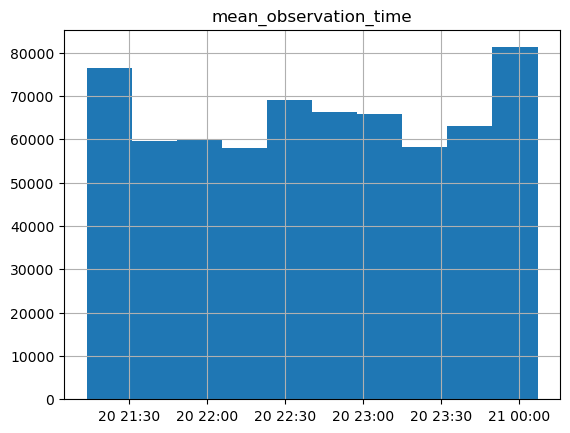

In [6]:
df.hist()